In [3]:
import os
import sys
import time
import warnings
import numpy as np
import rrsBdtDevDependencies
import dataFunctions as dataFun
from datetime import datetime as dt
from datetime import timedelta as td
import matplotlib.pyplot as plt
import pandas as pd
import quandl
QAPIKEY = "YpAydSEsKoSAfuQ9UKhu"
quandl.ApiConfig.api_key = QAPIKEY
import yfinance as yf
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import logging
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tqdm._tqdm_notebook import tqdm_notebook


In [34]:
### CONFIGURE ###

# Cost parameters set by the task for running ship for one day
barrels = 750000
costPerDay = 30000
daysToPredict = 1

# Data split for training and testing.
trainDataDate = '2010-01-01'
testSplitDate = '2019-11-26'

# Parameters for the model.
params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 200,
    "lr": 0.0010000,
    "time_steps": 60
}

# Replace with Cloud path with data later on
PATH_TO_DRIVE_ML_DATA = "/Users/qw19176/Documents/Courses/Team-Cpp"
INPUT_PATH = PATH_TO_DRIVE_ML_DATA+"/inputs/"
OUTPUT_PATH = PATH_TO_DRIVE_ML_DATA+"/outputs/"
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]

# Some environmental parameters.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TZ'] = 'Europe/London'
time.tzset()
stime = time.time()

modDate = dt.today().date()
dataDate = modDate - td(days=1)
updateData = False
is_update_model = True

dataFileName = "inputData_" + str(dataDate) + ".csv"
modFileName = "LSTM_" + str(modDate) + ".sav"

In [5]:
# check if directory already exists
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
    print("Directory created", OUTPUT_PATH)
else:
    raise Exception("Directory already exists. Don't override.")




Exception: Directory already exists. Don't override.

In [33]:
len(df)

2541

In [0]:
def print_time(text, stime):
    seconds = (time.time()-stime)
    print(text, seconds//60,"minutes : ",np.round(seconds%60),"seconds")

In [7]:
print('Running...')

def show_more(df, lines):
    with pd.option_context("display.max_rows", lines):
        display(df)

Running...


In [8]:
def create_features(fd, features, label=None, shift = 0, nonShiftFeatures = None):
    fd = fd.set_index('Date')
    #X = df[['OilProduction', 'NatGasPrices', 'BrentPrices', '20dSMA', 'Momentum_14', 'MACD_12_26', 'MACDdiff_12_26', 'ROC_14', 'RSI_14', 'bollAmplitude', 'distFromTopBoll', 'distFromLowBoll', '20d200dDist','dayofyear','dayofmonth','weekofyear']]

    # X = df[['OilProduction', '20dSMA', 'Momentum_14', 'MACD_12_26', 'MACDdiff_12_26', 'ROC_14', 'RSI_14', 'bollAmplitude', 'distFromTopBoll', 'distFromLowBoll', '20d200dDist','dayofyear','dayofmonth','weekofyear']]
    # if shift > 0:
    #     tiems = X[['dayofyear','dayofmonth','weekofyear']]
    #     #X = X[['OilProduction', 'NatGasPrices', 'BrentPrices', '20dSMA', 'Momentum_14', 'MACD_12_26', 'MACDdiff_12_26','ROC_14', 'RSI_14', 'bollAmplitude', 'distFromTopBoll', 'distFromLowBoll', '20d200dDist']].shift(shift)
    #     X = X[['OilProduction', '20dSMA', 'Momentum_14', 'MACD_12_26', 'MACDdiff_12_26','ROC_14', 'RSI_14', 'bollAmplitude', 'distFromTopBoll', 'distFromLowBoll', '20d200dDist']].shift(shift)
    #     X = X.merge(tiems, how='inner', left_index=True, right_index=True)

    X = fd[features]
    if shift > 0:
        tiems = fd[nonShiftFeatures]
        newFeatures = features
        for f in nonShiftFeatures:
            newFeatures.remove(f)
        X = X[newFeatures].shift(shift)
        X = X.merge(tiems, how='inner', left_index=True, right_index=True)
        X = X.iloc[shift:]

    if label:
        y = fd[label]
        return X, y
    return X

In [45]:
"""
Getting WTI price data 
"""

if (os.path.exists(INPUT_PATH+dataFileName) and updateData is False):
    df = pd.read_csv(INPUT_PATH+dataFileName)
    print("Dataframe already exists, reading from file...")
else:
    print("Datafile not found, querying data and building dataframe...")
    wtiData         = quandl.get("FRED/DCOILWTICO")
    wtiData.reset_index(level=0, inplace=True)
    wtiData         = wtiData.rename(columns={"Value": "Prices"})
    yfStartDate     = wtiData['Date'].iloc[-1].strftime('%Y-%m-%d')
    stocks          = "CL=F"
    period          = "1d"
    Stocks, yfInfo  = dataFun.yFinData(yfStartDate)
    wtiData         = wtiData.append(Stocks, ignore_index =True)
    wtiData         = wtiData.sort_values(by = ["Date"])

    # Getting Oil production data and combining dataframes
    oilDF   = dataFun.oilProduction()
    df      = dataFun.combineFrames(wtiData,oilDF)
    df      = df[np.isfinite(df['Prices'])]
    df      = df.reset_index().drop(["index"], axis = 1)

    # Getting natural gas data and combining frames
    natGasData          = quandl.get("EIA/NG_RNGWHHD_D")
    natGasData.reset_index(level=0, inplace=True)
    natGasData          = natGasData.rename(columns={"Value": "NatGasPrices"})
    yfStartDate         = natGasData['Date'].iloc[-1].strftime('%Y-%m-%d')
    stocks              = "NG=F"
    period              = "1d"
    NGStocks, yfInfo    = dataFun.yFinData(yfStartDate,stock=stocks,name ="NatGasPrices")
    natGasData          = natGasData.append(NGStocks, ignore_index =True)
    natGasData          = natGasData.sort_values(by = ["Date"])
    newdf               = pd.merge(df, natGasData, on=['Date'], how ="left")

    """
    Getting Brent oil data and combining dataframes
    """

    brentData = quandl.get("FRED/DCOILBRENTEU")
    brentData.reset_index(level=0, inplace=True)
    name = "BrentPrices"
    brentData = brentData.rename(columns={"Value": name})
    yfStartDate = brentData['Date'].iloc[-1].strftime('%Y-%m-%d')
    stocks = "BZ=F"
    period = "1d"
    BStocks, yfInfo = dataFun.yFinData(yfStartDate,stock=stocks,name = name)
    brentData = brentData.append(BStocks, ignore_index =True)
    brentData = brentData.sort_values(by = ["Date"])
    df = pd.merge(newdf, brentData, on=['Date'], how ="left")

    df["BrentPrices"] = df["BrentPrices"].interpolate(method='nearest')
    df["NatGasPrices"] = df["NatGasPrices"].interpolate(method='nearest')

    # Calculating the technical indicators for price data
    df = df.reset_index().drop(["index"], axis = 1)
    df["20dSMA"] = dataFun.SMA(20, df["Prices"])
    df["10dSMA"] = dataFun.SMA(10, df["Prices"])
    df["5dSMA"] = dataFun.SMA(5, df["Prices"])
    df["50dSMA"] = dataFun.SMA(50, df["Prices"])
    df["200dSMA"] = dataFun.SMA(200, df["Prices"])


    df["boll_lo"] = dataFun.bollinger(df['Prices'])[0]
    df["boll_hi"] = dataFun.bollinger(df['Prices'])[1]

    df = dataFun.momentum(df, 14)
    df = dataFun.macd(df, 12, 26)
    df = dataFun.rate_of_change(df, 14)
    df = dataFun.relative_strength_index(df)

    df["boll_hi"] = pd.to_numeric(df["boll_hi"])
    df["boll_lo"] = pd.to_numeric(df["boll_lo"])
    df["20dSMA"] = pd.to_numeric(df["20dSMA"])
    df["10dSMA"] = pd.to_numeric(df["10dSMA"])
    df["5dSMA"] = pd.to_numeric(df["5dSMA"])
    df["50dSMA"] = pd.to_numeric(df["50dSMA"])
    df["200dSMA"] = pd.to_numeric(df["200dSMA"])

    df["bollAmplitude"] = df["boll_hi"] - df["boll_lo"]
    df["distFromTopBoll"] = df["boll_hi"] - df["Prices"]
    df["distFromLowBoll"] = df["boll_lo"] - df["Prices"]
    df["20d200dDist"] = np.abs(df["20dSMA"] - df["200dSMA"])

    df = df[np.isfinite(df['200dSMA'])]
    df = df.rename(columns={"Production of Crude Oil": "OilProduction"})
    df = df.drop_duplicates("Date",keep="first")
    df = df[np.isfinite(df['Prices'])]
    df = df.reset_index().drop(["index"], axis = 1)

    """
    Creating time series features from datetime index
    """

    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.weekofyear

    print("Saving dataframe to file ", dataFileName, "at ", INPUT_PATH)
    df.to_csv(INPUT_PATH+dataFileName)


Dataframe already exists, reading from file...


In [46]:
df.tail()

,Unnamed: 0,Date,Prices,OilProduction,NatGasPrices,BrentPrices,20dSMA,10dSMA,5dSMA,50dSMA,...,distFromTopBoll,distFromLowBoll,20d200dDist,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
8393,8393,2020-02-04,49.680000,12900.0,1.879,53.880001,52.4595,49.049999,45.225999,57.0044,...,16.677633,-11.118634,4.26465,1,1,2,2020,35,4,6
8394,8394,2020-02-05,51.230000,12900.0,1.874,55.630001,52.1280,48.875999,50.359999,56.9096,...,14.568172,-12.772171,4.53585,2,1,2,2020,36,5,6
8395,8395,2020-02-06,51.369999,12900.0,1.864,55.380001,51.7705,48.630999,50.431999,56.8140,...,13.736722,-12.935721,4.83325,3,1,2,2020,37,6,6
8396,8396,2020-02-07,50.340000,12900.0,1.850,54.450001,51.3600,48.354999,50.512000,56.6516,...,13.977621,-11.937622,5.17630,4,1,2,2020,38,7,6
8397,8397,2020-02-09,49.759998,12900.0,1.791,53.849998,50.9355,48.045999,50.475999,56.4784,...,13.732812,-11.381809,5.53185,6,1,2,2020,40,9,6


In [47]:
df.describe()

,Unnamed: 0,Prices,OilProduction,NatGasPrices,BrentPrices,20dSMA,10dSMA,5dSMA,50dSMA,200dSMA,...,distFromTopBoll,distFromLowBoll,20d200dDist,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
count,8398.000000,8398.000000,8398.000000,5799.000000,8252.000000,8398.000000,8398.000000,8398.000000,8398.000000,8398.000000,...,8398.000000,8398.000000,8398.000000,8398.000000,8398.000000,8398.000000,8398.000000,8398.000000,8398.000000,8398.000000
mean,4198.500000,44.891117,6984.149440,4.265830,46.581690,44.849520,44.871414,44.882828,44.774408,44.392109,...,3.103497,-3.186692,5.345580,2.014765,2.514170,6.541915,2002.900929,183.682663,15.718147,26.632889
std,2424.438114,29.156473,1743.195751,2.224215,32.709505,29.102718,29.128116,29.141534,29.013005,28.428070,...,4.148823,3.441550,7.426571,1.400597,1.118437,3.443357,9.636983,105.150503,8.744190,15.026249
min,0.000000,10.820000,3813.000000,1.050000,9.100000,11.228500,11.214000,10.990000,11.871200,13.363850,...,-3.635005,-32.589390,0.001100,0.000000,1.000000,1.000000,1986.000000,2.000000,1.000000,1.000000
25%,2099.250000,19.930000,5721.000000,2.710000,18.750000,19.924000,19.930500,19.946000,19.958250,20.002450,...,0.738547,-4.409868,1.398438,1.000000,2.000000,4.000000,1995.000000,92.000000,8.000000,14.000000
50%,4198.500000,32.150000,6498.500000,3.600000,31.610000,32.058250,31.976500,32.108000,31.997400,30.657400,...,1.737674,-2.078052,2.931450,2.000000,3.000000,7.000000,2003.000000,184.000000,16.000000,27.000000
75%,6297.750000,64.020000,8026.000000,5.320000,67.532500,63.973875,64.265000,64.193500,63.632900,64.429062,...,3.816038,-0.856189,6.286425,3.000000,4.000000,10.000000,2011.000000,275.000000,23.000000,40.000000
max,8397.000000,145.310000,13000.000000,18.480000,143.950000,138.824000,141.498000,142.290000,133.324400,112.504950,...,51.571503,14.144700,60.175500,6.000000,4.000000,12.000000,2020.000000,366.000000,31.000000,53.000000


In [48]:
df[df.isna().any(axis=1)]

,Unnamed: 0,Date,Prices,OilProduction,NatGasPrices,BrentPrices,20dSMA,10dSMA,5dSMA,50dSMA,...,distFromTopBoll,distFromLowBoll,20d200dDist,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,0,1986-10-17,14.85,8773.0,NaN,NaN,14.7820,14.943,14.748,15.0912,...,0.764336,-0.900336,0.09925,4,4,10,1986,290,17,42
1,1,1986-10-20,15.17,8773.0,NaN,NaN,14.8170,14.974,14.786,15.0910,...,0.482958,-1.188958,0.01010,0,4,10,1986,293,20,43
2,2,1986-10-21,15.22,8773.0,NaN,NaN,14.8810,15.013,14.920,15.0988,...,0.405210,-1.083210,0.11045,1,4,10,1986,294,21,43
3,3,1986-10-22,14.85,8773.0,NaN,NaN,14.9085,14.938,14.924,15.0974,...,0.751177,-0.634177,0.19295,2,4,10,1986,295,22,43
4,4,1986-10-23,14.88,8773.0,NaN,NaN,14.9250,14.891,14.994,15.0850,...,0.717137,-0.627137,0.26440,3,4,10,1986,296,23,43
5,5,1986-10-24,14.93,8773.0,NaN,NaN,14.9575,14.879,15.010,15.0780,...,0.627285,-0.572285,0.35240,4,4,10,1986,297,24,43
6,6,1986-10-27,14.40,8773.0,NaN,NaN,14.9560,14.821,14.856,15.0574,...,1.161463,-0.049463,0.40715,0,4,10,1986,300,27,44
7,7,1986-10-28,14.18,8773.0,NaN,NaN,14.9185,14.784,14.648,15.0244,...,1.436566,0.040434,0.42415,1,4,10,1986,301,28,44
8,8,1986-10-29,13.73,8773.0,NaN,NaN,14.8700,14.674,14.424,14.9874,...,2.014480,0.265520,0.43185,2,4,10,1986,302,29,44
9,9,1986-10-30,15.08,8773.0,NaN,NaN,14.8625,14.729,14.464,14.9894,...,0.646490,-1.081490,0.47485,3,4,10,1986,303,30,44


In [49]:
# cols = df.columns
# for i, col in enumerate(cols):
#     print (i,cols[i])
#     if i > 2 and i < 22:

#         if "boll_" in cols[i]:
#             dataFun.plot2axis(x = df["Date"], y1 = df["Prices"], y2 = None, y2_name = None , y_name = cols[i], fill_boll = True, bol_low = df["boll_lo"], bol_high = df["boll_hi"], bol_name = "20d Bollinger Bands")
#             plt.title('WTI Stock Price Bollinger Bands')
#             plt.savefig(os.path.join(OUTPUT_PATH+"featurePlots/", 'BollingerBands.png'))

#         else:
#             dataFun.plot2axis(x = df["Date"], y1 = df[cols[i]], y2 = df["Prices"], y_name = cols[i])
#             plt.title("WTI Price & "+cols[i])
#             plt.savefig(os.path.join(OUTPUT_PATH+"featurePlots/", cols[i] + '.png'))

#         plt.clf()

In [50]:
# cols
# plt.style.use("seaborn")
# fig, ax = plt.subplots()
# color = 'tab:green'
# ax.set_xlabel("Date", size=16)
# ax.set_ylabel("WTI Price", size=16, color=color)
# ax.plot(df["Date"], df["Prices"], lw=1, color=color, label="WTI Price")
# ax.tick_params(axis='y', labelcolor=color)
# ax.fill_between(df["Date"], df["boll_hi"], df["boll_lo"], color='blue', alpha=0.75)

# ax.legend(loc='upper left', prop={'size': 16})

# ax2 = ax.twinx()
# color = 'tab:blue'

# # we already handled the x-label with ax
# # ax2.set_ylabel(y2_name, size=14, color=color)
# # ax2.plot(x, y2, color=color, lw=1.5, label=y2_name)
# # ax2.tick_params(axis='y', labelcolor=color)
# fig.tight_layout()
# plt.show()
# plt.savefig(os.path.join(OUTPUT_PATH+"featurePlots/", 'BollingerBands.png'))

In [51]:
# cols = df.columns
# dataFun.plot2axis(x = df["Date"], y1 = df["Prices"], y2 = None, y2_name = None , y_name = "WTI Price", fill_boll = True, bol_low = df["boll_lo"], bol_high = df["bol_hi"], bol_name = "20d Bollinger Bands")
# plt.title('WTI Stock Price Bollinger Bands')
# plt.savefig(os.path.join(OUTPUT_PATH+"featurePlots/", 'BollingerBands.png'))

In [52]:
df = df[df["Date"] > trainDataDate]
df = df.reset_index().drop(["index"], axis = 1)
# df_train = df[df["Date"] <= testSplitDate].copy()
# df_test = df[df["Date"] > testSplitDate].copy()
df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
# df_train, df_test = train_test_split(df, train_size=0.9, test_size=0.1, shuffle=False)

# training_set = df.set_index('Date')
# training_set = training_set[features]
feat = ['Prices']#,'OilProduction', 'Momentum_14', 'RSI_14','distFromTopBoll', 'dayofmonth', 'weekofyear']#,'Momentum_14', 'MACD_12_26', 'RSI_14','20d200dDist','dayofmonth','weekofyear']
nonShiftFeat = ['Prices','dayofmonth','weekofyear']
#['OilProduction', '20dSMA', 'Momentum_14', 'MACD_12_26', 'MACDdiff_12_26', 'ROC_14', 'RSI_14', 'bollAmplitude', 'distFromTopBoll', 'distFromLowBoll', '20d200dDist','dayofyear','dayofmonth','weekofyear']


# X_train, y_train = create_features(df_train,features,label='Prices', shift =1)
# X_test, y_test = create_features(df_test,label='Prices', shift =1)
# X_train = X_train.iloc[1:]
# X_test = X_test.iloc[1:]
# y_train = y_train.iloc[1:]
# y_test = y_test.iloc[1:]

In [53]:
X = df[feat]
df_train[feat]
df_train[df_train.isna().any(axis=1)]
test = df_train.iloc[1:]
test

,Unnamed: 0,Date,Prices,OilProduction,NatGasPrices,BrentPrices,20dSMA,10dSMA,5dSMA,50dSMA,...,distFromTopBoll,distFromLowBoll,20d200dDist,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
1,5857,2010-01-05,81.74,5507.0,6.19,79.27,74.7380,77.859,80.174,76.6768,...,0.961614,-14.965614,7.20645,1,1,1,2010,5,5,1
2,5858,2010-01-06,83.12,5507.0,6.47,80.14,75.1995,78.900,81.024,76.7370,...,0.863697,-16.704697,7.51760,2,1,1,2010,6,6,1
3,5859,2010-01-07,82.60,5507.0,7.51,80.57,75.7000,79.812,81.674,76.8168,...,2.384600,-16.184600,7.87190,3,1,1,2010,7,7,1
4,5860,2010-01-08,82.74,5496.0,6.56,80.06,76.3035,80.483,82.344,76.8826,...,3.038614,-15.911614,8.32290,4,1,1,2010,8,8,1
5,5861,2010-01-11,82.54,5496.0,5.77,80.14,76.9035,81.054,82.548,76.9856,...,3.821668,-15.094668,8.77955,0,1,1,2010,11,11,2
6,5862,2010-01-12,80.79,5496.0,5.57,79.38,77.4500,81.266,82.358,77.0046,...,5.656388,-12.336388,9.18415,1,1,1,2010,12,12,2
7,5863,2010-01-13,79.66,5496.0,5.61,77.57,77.9590,81.345,81.666,77.0570,...,6.514810,-9.916810,9.53730,2,1,1,2010,13,13,2
8,5864,2010-01-14,79.35,5496.0,5.77,77.61,78.3955,81.345,81.016,77.0824,...,6.513130,-8.422130,9.82525,3,1,1,2010,14,14,2
9,5865,2010-01-15,77.96,5404.0,5.66,76.85,78.6615,81.202,80.060,77.0500,...,7.668110,-6.265110,9.94375,4,1,1,2010,15,15,2
10,5866,2010-01-19,78.98,5404.0,5.51,75.18,78.9815,80.948,79.348,77.0236,...,6.352690,-6.349690,10.13190,1,1,1,2010,19,19,3


In [54]:
df_train = create_features(df_train,features=feat, shift = 0, nonShiftFeatures=nonShiftFeat)
feat = ['Prices']#,'OilProduction', 'Momentum_14', 'RSI_14','distFromTopBoll', 'dayofmonth', 'weekofyear']#,'Momentum_14', 'MACD_12_26', 'RSI_14','20d200dDist','dayofmonth','weekofyear']
nonShiftFeat = ['Prices','dayofmonth','weekofyear']
df_test = create_features(df_test,features=feat, shift = 0, nonShiftFeatures=nonShiftFeat)



In [91]:
feat = ['Prices']#,'OilProduction', 'Momentum_14', 'RSI_14','distFromTopBoll', 'dayofmonth', 'weekofyear']#,'Momentum_14', 'MACD_12_26', 'RSI_14','20d200dDist','dayofmonth','weekofyear']
nonShiftFeat = ['Prices','dayofmonth','weekofyear']
x = df_train.loc[:,feat].values
x

array([[81.52],
       [81.74],
       [83.12],
       ...,
       [65.69],
       [65.62],
       [66.27]])

In [56]:

sc = MinMaxScaler(feature_range=(0,1))

x_train = sc.fit_transform(x)
x_test = sc.transform(df_test.loc[:,feat])
x_train

array([[0.63451835],
       [0.63704128],
       [0.65286697],
       ...,
       [0.45298165],
       [0.4521789 ],
       [0.45963303]])

In [58]:
def build_timeseries(mat, y_col_index):
    """
    Converts ndarray into timeseries format and supervised data format. Takes first TIME_STEPS
    number of rows as input and sets the TIME_STEPS+1th data as corresponding output and so on.
    :param mat: ndarray which holds the dataset
    :param y_col_index: index of column which acts as output
    :return: returns two ndarrays-- input and output in format suitable to feed
    to LSTM.
    """
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print("dim_0",dim_0)
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
#         if i < 10:
#           print(i,"-->", x[i,-1,:], y[i])
    print("length of time-series i/o",x.shape,y.shape)
    return x, y


def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [59]:
tqdm_notebook.pandas('Processing...')
# df_ge = process_dataframe(df_ge)
print(df.shape)
print(df.columns)
print(df.dtypes)
print("Train--Test size", len(df_train), len(df_test))

(2541, 30)
Index(['Unnamed: 0', 'Date', 'Prices', 'OilProduction', 'NatGasPrices',
       'BrentPrices', '20dSMA', '10dSMA', '5dSMA', '50dSMA', '200dSMA',
       'boll_lo', 'boll_hi', 'Momentum_14', 'MACD_12_26', 'MACDsign_12_26',
       'MACDdiff_12_26', 'ROC_14', 'RSI_14', 'bollAmplitude',
       'distFromTopBoll', 'distFromLowBoll', '20d200dDist', 'dayofweek',
       'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear'],
      dtype='object')
Unnamed: 0           int64
Date                object
Prices             float64
OilProduction      float64
NatGasPrices       float64
BrentPrices        float64
20dSMA             float64
10dSMA             float64
5dSMA              float64
50dSMA             float64
200dSMA            float64
boll_lo            float64
boll_hi            float64
Momentum_14        float64
MACD_12_26         float64
MACDsign_12_26     float64
MACDdiff_12_26     float64
ROC_14             float64
RSI_14             float64
bollAmplitude      flo

In [60]:
print("Are any NaNs present in train/test matrices?",np.isnan(x_train).any(), np.isnan(x_train).any())
target_idx = 0
x_t, y_t = build_timeseries(x_train, target_idx)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
print("Batch trimmed size",x_t.shape, y_t.shape)

Are any NaNs present in train/test matrices? False False
dim_0 1972



length of time-series i/o (1972, 60, 1) (1972,)
Batch trimmed size (1960, 60, 1) (1960,)


In [120]:
x_test_t

array([[[0.28497706],
        [0.30389908],
        [0.2875    ],
        ...,
        [0.35091743],
        [0.35206422],
        [0.36788991]],

       [[0.30389908],
        [0.2875    ],
        [0.27075688],
        ...,
        [0.35206422],
        [0.36788991],
        [0.37155963]],

       [[0.2875    ],
        [0.27075688],
        [0.22855505],
        ...,
        [0.36788991],
        [0.37155963],
        [0.3706422 ]],

       ...,

       [[0.33727064],
        [0.33428899],
        [0.32866972],
        ...,
        [0.35057339],
        [0.33623853],
        [0.31995413]],

       [[0.33428899],
        [0.32866972],
        [0.31915138],
        ...,
        [0.33623853],
        [0.31995413],
        [0.30848624]],

       [[0.32866972],
        [0.31915138],
        [0.34231651],
        ...,
        [0.31995413],
        [0.30848624],
        [0.31685779]]])

In [61]:
x_temp, y_temp = build_timeseries(x_test, target_idx)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)


dim_0 449



length of time-series i/o (449, 60, 1) (449,)
Test size (220, 60, 1) (220,) (220, 60, 1) (220,)


In [63]:
# lr = 0.1
# lstm_model = Sequential()
# lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
# lstm_model.add(Dropout(0.5))
# lstm_model.add(Dense(20,activation='relu'))
# lstm_model.add(Dense(1,activation='sigmoid'))
# optimizer = optimizers.RMSprop(lr=lr)
# lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

def create_model():
    lstm_model = Sequential()
    # (batch_size, timesteps, data_dim)
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(LSTM(60, dropout=0.0))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(Dense(20,activation='relu'))
    lstm_model.add(Dense(1,activation='sigmoid'))
    optimizer = optimizers.RMSprop(lr=params["lr"])
    # optimizer = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    return lstm_model

# model = Sequential()
# model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50,return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50,return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50))
# model.add(Dropout(0.2))
# model.add(Dense(units=1))
# model.compile(optimizer='adam',loss='mean_squared_error')
# model.fit(X_train,y_train,epochs=100,batch_size=32)

In [64]:
model = None
try:
    model = pickle.load(open(modFileName, 'rb'))
    print("Loaded saved model...")
except FileNotFoundError:
    print("Model not found")

if model is None or is_update_model:
    from keras import backend as K
    print("Building model...")
    print("checking if GPU available", K.tensorflow_backend._get_available_gpus())
    model = create_model()
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=40, min_delta=0.0001)
    
    mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,
                          "best_model.h5"), monitor='val_loss', verbose=1,
                          save_best_only=True, save_weights_only=False, mode='min', period=1)

    # Not used here. But leaving it here as a reminder for future
    r_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, 
                                  verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    
    csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'training_log_' + time.ctime().replace(" ","_") + '.log'), append=True)
    
    history = model.fit(x_t, y_t, epochs=params["epochs"], verbose=2, batch_size=BATCH_SIZE,
                        shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                        trim_dataset(y_val, BATCH_SIZE)), callbacks=[es, mcp, csv_logger])
    
    print("saving model...")
    pickle.dump(model, open(modFileName, "wb"))


Loaded saved model...
Building model...
checking if GPU available []
Train on 1960 samples, validate on 220 samples
Epoch 1/200
 - 7s - loss: 0.0082 - val_loss: 0.0120

Epoch 00001: val_loss improved from inf to 0.01204, saving model to /Users/qw19176/Documents/Courses/Team-Cpp/outputs/best_model.h5
Epoch 2/200
 - 6s - loss: 0.0069 - val_loss: 0.0111

Epoch 00002: val_loss improved from 0.01204 to 0.01107, saving model to /Users/qw19176/Documents/Courses/Team-Cpp/outputs/best_model.h5
Epoch 3/200
 - 6s - loss: 0.0093 - val_loss: 0.0129

Epoch 00003: val_loss did not improve from 0.01107
Epoch 4/200
 - 6s - loss: 0.0059 - val_loss: 0.0112

Epoch 00004: val_loss did not improve from 0.01107
Epoch 5/200
 - 6s - loss: 0.0057 - val_loss: 0.0114

Epoch 00005: val_loss did not improve from 0.01107
Epoch 6/200
 - 6s - loss: 0.0065 - val_loss: 0.0097

Epoch 00006: val_loss improved from 0.01107 to 0.00970, saving model to /Users/qw19176/Documents/Courses/Team-Cpp/outputs/best_model.h5
Epoch 7/2

In [65]:
# OUTPUT_PATH = "/Users/qw19176/Documents/Courses/Team-Cpp/"
# csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'LSTMRegressor' + '.log'), append=True)
# epochs = 100
# history = lstm_model.fit(x_t, y_t, epochs=epochs, verbose=2, batch_size=BATCH_SIZE,
#                     shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
#                     trim_dataset(y_val, BATCH_SIZE)), callbacks=[csv_logger])

In [66]:
# search_params = {
#     "batch_size": [20, 30, 40],
#     "time_steps": [30, 60, 90], 
#     "lr": [0.01, 0.001, 0.0001],
#     "epochs": [30, 50, 70]
# }

# def eval_model():
#     """
#     implement your logic to build a model, train it and then calculate validation loss.
#     Save this validation loss using CSVLogger of Keras or in a text file. Later you can
#     query to get the best combination.
#     """
#     pass

# def get_all_combinations(params):
#     all_names = params.keys()
#     combinations = it.product(*(params[name] for name in all_names))
#     return list(combinations)

# def run_search(mat, params):
#     param_combs = get_all_combinations(params) # list of tuples
#     logging.info("Total combinations to try = {}".format(len(param_combs)))
#     for i, combination in enumerate(param_combs):
#         logging.info("Trying combo no. {} {}".format(i, combination))
#         eval_model(mat, combination, i)

# run_search(x_input, search_params)

In [67]:
# model.evaluate(x_test_t, y_test_t, batch_size=BATCH_SIZE
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

Error is 0.0013210527813349525 (220,) (220,)
[0.39867485 0.40462056 0.40242013 0.40526265 0.4073942  0.41652066
 0.41830784 0.40688497 0.40189222 0.41347125 0.41452676 0.4104599
 0.41691867 0.43285426 0.44714856]
[0.37155963 0.3706422  0.37729358 0.37763761 0.3891055  0.3875
 0.37477064 0.37293578 0.38623853 0.38073394 0.37958716 0.38990826
 0.4059633  0.41674312 0.41594037]


In [68]:
# convert the predicted value to range of real data
y_pred_org = (y_pred * sc.data_range_[target_idx]) + sc.data_min_[target_idx]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * sc.data_range_[target_idx]) + sc.data_min_[target_idx]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

[60.954445 61.472916 61.281036 61.5289   61.714775 62.510597 62.666443
 61.670372 61.235    62.24469  62.33673  61.9821   62.545303 63.93489
 65.18135 ]
[58.59 58.51 59.09 59.12 60.12 59.98 58.87 58.71 59.87 59.39 59.29 60.19
 61.59 62.53 62.46]


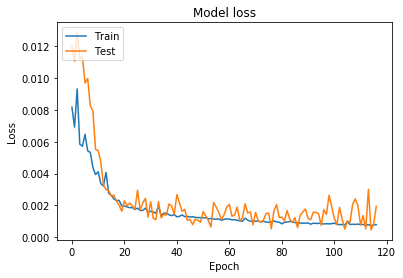

In [69]:
# Visualize the training data
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'train_vis_BS_'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))

In [70]:
# load the saved best model from above
saved_model = load_model(os.path.join(OUTPUT_PATH, 'best_model.h5')) # , "lstm_best_7-3-19_12AM",
print(saved_model)

In [71]:
y_pred = saved_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])
y_pred_org = (y_pred * sc.data_range_[target_idx]) + sc.data_min_[target_idx] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * sc.data_range_[target_idx]) + sc.data_min_[target_idx] # min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

Error is 0.0002421729313841263 (220,) (220,)
[0.37199724 0.37820834 0.37675205 0.38012508 0.38271365 0.39215118
 0.3945283  0.38397157 0.37929302 0.39053422 0.39164287 0.38787925
 0.39436257 0.41031218 0.4227859 ]
[0.37155963 0.3706422  0.37729358 0.37763761 0.3891055  0.3875
 0.37477064 0.37293578 0.38623853 0.38073394 0.37958716 0.38990826
 0.4059633  0.41674312 0.41594037]
[58.62816  59.16977  59.042778 59.336906 59.56263  60.385582 60.592865
 59.672318 59.26435  60.244583 60.341255 60.01307  60.578415 61.969223
 63.05693 ]
[58.59 58.51 59.09 59.12 60.12 59.98 58.87 58.71 59.87 59.39 59.29 60.19
 61.59 62.53 62.46]


program completed  311.0 minutes :  44.0 seconds


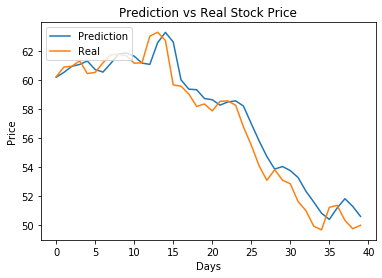

In [329]:
# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org[-40:])
plt.plot(y_new_t_org[-40:])
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
#plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))
print_time("program completed ", stime)

In [328]:
y_pred = saved_model.predict(trim_dataset(x_new_t,BATCH_SIZE), batch_size=BATCH_SIZE)
#y_pred = y_pred.flatten()
y_new_t = trim_dataset(y_new_t, BATCH_SIZE)
error = mean_squared_error(y_new_t, y_pred)
print("Mean squared error is", error, y_pred.shape, y_new_t.shape)
# print(y_pred[0:15])
# print(y_test_t[0:15])
y_pred_org = (y_pred * sc.data_range_[target_idx]) + sc.data_min_[target_idx] # min_max_scaler.inverse_transform(y_pred)
y_new_t_org = (y_new_t * sc.data_range_[target_idx]) + sc.data_min_[target_idx] # min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[-40:])
print(y_new_t_org[-40:-23])

Mean squared error is 0.0001432833433995178 (40, 1) (40,)
[[60.17411 ]
 [60.5139  ]
 [60.926453]
 [61.055252]
 [61.289764]
 [60.704796]
 [60.53237 ]
 [61.12892 ]
 [61.77507 ]
 [61.843475]
 [61.623512]
 [61.147736]
 [61.06031 ]
 [62.54657 ]
 [63.261375]
 [62.596306]
 [59.996803]
 [59.356224]
 [59.31865 ]
 [58.711815]
 [58.63096 ]
 [58.259315]
 [58.479164]
 [58.551643]
 [58.195404]
 [56.98227 ]
 [55.805183]
 [54.723244]
 [53.86067 ]
 [54.037987]
 [53.758904]
 [53.280983]
 [52.34205 ]
 [51.602795]
 [50.827827]
 [50.400116]
 [51.188347]
 [51.82317 ]
 [51.297894]
 [50.606815]]
[60.21 60.88 60.93 61.3  60.43 60.51 61.17 61.72 61.76 61.66 61.14 61.17
 63.   63.27 62.7  59.65 59.56]


In [327]:
to_pred = df["Prices"][-139:].values
to_pred = np.append(to_pred,50)
# trim_dataset(x_test_t, BATCH_SIZE)
to_pred = sc.transform(to_pred.reshape(-1,1))
x_new, y_new = build_timeseries(to_pred, target_idx)
x_newval, x_new_t = np.split(trim_dataset(x_new,BATCH_SIZE),2)
y_newval, y_new_t = np.split(trim_dataset(y_new,BATCH_SIZE),2)
to_pred.shape
# print("Test size", x_new_t.shape, y_new_t.shape, x_newval.shape, y_newval.shape)

dim_0 80



length of time-series i/o (80, 60, 1) (80,)


(140, 1)

In [289]:
# np.append(to_pred,np.nan)
to_pred

array([[0.39094037],
       [0.38692661],
       [0.38761468],
       [0.37970183],
       [0.35837156],
       [0.34759174],
       [0.33130734],
       [0.33520642],
       [0.34036697],
       [0.34850917],
       [0.34071101],
       [0.34048165],
       [0.34231651],
       [0.3516055 ],
       [0.36525229],
       [0.37087156],
       [0.31479358],
       [0.33807339],
       [0.32614679],
       [0.31433486],
       [0.28612385],
       [0.30286697],
       [0.32362385],
       [0.33016055],
       [0.35389908],
       [0.33222477],
       [0.32477064],
       [0.32844037],
       [0.34461009],
       [0.34392202],
       [0.33784404],
       [0.33417431],
       [0.31983945],
       [0.31364679],
       [0.33027523],
       [0.3391055 ],
       [0.34954128],
       [0.33119266],
       [0.31788991],
       [0.34438073],
       [0.3456422 ],
       [0.34701835],
       [0.36341743],
       [0.35756881],
       [0.33795872],
       [0.33188073],
       [0.32763761],
       [0.423

In [278]:
df["Prices"][-61:]

2480    56.670000
2481    56.880000
2482    56.570000
2483    57.540000
2484    56.820000
          ...    
2536    49.680000
2537    51.230000
2538    51.369999
2539    50.340000
2540    49.759998
Name: Prices, Length: 61, dtype: float64

In [176]:
df.tail(5)

,Unnamed: 0,Date,Prices,OilProduction,NatGasPrices,BrentPrices,20dSMA,10dSMA,5dSMA,50dSMA,...,distFromTopBoll,distFromLowBoll,20d200dDist,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
2536,8393,2020-02-04,49.680000,12900.0,1.879,53.880001,52.4595,49.049999,45.225999,57.0044,...,16.677633,-11.118634,4.26465,1,1,2,2020,35,4,6
2537,8394,2020-02-05,51.230000,12900.0,1.874,55.630001,52.1280,48.875999,50.359999,56.9096,...,14.568172,-12.772171,4.53585,2,1,2,2020,36,5,6
2538,8395,2020-02-06,51.369999,12900.0,1.864,55.380001,51.7705,48.630999,50.431999,56.8140,...,13.736722,-12.935721,4.83325,3,1,2,2020,37,6,6
2539,8396,2020-02-07,50.340000,12900.0,1.850,54.450001,51.3600,48.354999,50.512000,56.6516,...,13.977621,-11.937622,5.17630,4,1,2,2020,38,7,6
2540,8397,2020-02-09,49.759998,12900.0,1.791,53.849998,50.9355,48.045999,50.475999,56.4784,...,13.732812,-11.381809,5.53185,6,1,2,2020,40,9,6


In [ ]:
"""
TALOS OPTIMISATION

NOT IMPLEMENTED YET
"""

def data(search_params):
    """
    The function that prepares the data for LSTM training specific to this problem as per values in search_params.
    """
    global mat

    BATCH_SIZE = search_params["batch_size"]
    TIME_STEPS = search_params["time_steps"]
    x_train, x_test = train_test_split(mat, train_size=0.8, test_size=0.2, shuffle=False)

    # scale the train and test dataset
    min_max_scaler = MinMaxScaler()
    x_train = min_max_scaler.fit_transform(x_train)
    x_test = min_max_scaler.transform(x_test)

    x_train_ts, y_train_ts = build_timeseries(x_train, 3, TIME_STEPS)
    x_test_ts, y_test_ts = build_timeseries(x_test, 3, TIME_STEPS)
    x_train_ts = trim_dataset(x_train_ts, BATCH_SIZE)
    y_train_ts = trim_dataset(y_train_ts, BATCH_SIZE)
    x_test_ts = trim_dataset(x_test_ts, BATCH_SIZE)
    y_test_ts = trim_dataset(y_test_ts, BATCH_SIZE)
    print("Test size(trimmed) {}, {}".format(x_test_ts.shape, y_test_ts.shape))
    return x_train_ts, y_train_ts, x_test_ts, y_test_ts
  
  def create_model_talos(x_train_ts, y_train_ts, x_test_ts, y_test_ts, params):
    """
    function that builds model, trains, evaluates on validation data and returns Keras history object and model for
    talos scanning. Here I am creating data inside function because data preparation varies as per the selected value of 
    batch_size and time_steps during searching. So we ignore data that's received here as argument from scan method of Talos.
    """
    x_train_ts, y_train_ts, x_test_ts, y_test_ts = data(params)
    BATCH_SIZE = params["batch_size"]
    TIME_STEPS = params["time_steps"]
    lstm_model = Sequential()
    # (batch_size, timesteps, data_dim)
    lstm_model.add(LSTM(params["lstm1_nodes"], batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_train_ts.shape[2]), dropout=0.2,
                        recurrent_dropout=0.2, stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))
    if params["lstm_layers"] == 2:
        lstm_model.add(LSTM(params["lstm2_nodes"], dropout=0.2))
    else:
        lstm_model.add(Flatten())

    if params["dense_layers"] == 2:
        lstm_model.add(Dense(params["dense2_nodes"], activation='relu'))

    lstm_model.add(Dense(1, activation='sigmoid'))
    if params["optimizer"] == 'rms':
        optimizer = optimizers.RMSprop(lr=params["lr"])
    else:
        optimizer = optimizers.SGD(lr=params["lr"], decay=1e-6, momentum=0.9, nesterov=True)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)  # binary_crossentropy
    history = lstm_model.fit(x_train_ts, y_train_ts, epochs=params["epochs"], verbose=2, batch_size=BATCH_SIZE,
                             validation_data=[x_test_ts, y_test_ts],
                             callbacks=[LogMetrics(search_params, params, -1), csv_logger])
    return history, lstm_model
  
print("Starting Talos scanning...")
t = ta.Scan(x=mat, # data parameter is ignored in this example as here data varies based on batch_size & time_steps
            y=mat[:,0], # dummy data just to avoid errors. input and output calculated in create_model_talos
            model=create_model_talos,
            params=search_params,
            dataset_name='stock_ge',
            experiment_no='1',
            reduction_interval=10)

pickle.dump(t, open(os.path.join(OUTPUT_PATH,"talos_res"),"wb"))

In [5]:
features = ["easy", "easter", "eastmas", "estover"]
nonShiftFeatures = ["easy", "easter"]


In [7]:
for f in nonShiftFeatures:
    features.remove(f)
features

['eastmas', 'estover']